# Gradient Matching Attack on a Pytorch Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

# min_ = (min_-mean)/(std+1e-7)
# max_ = (max_-mean)/(std+1e-7)


# Model from: https://github.com/kuangliu/pytorch-cifar
# MIT License
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet_18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, test_loader, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25, x_trigger=None, y_trigger=None):
    if x_test==None or y_test==None:
        x_test = x_train
        y_test = y_train
    model = resnet_18()

    if x_trigger is not None:
        assert(x_trigger.shape[0] == 1)
        x_trigger = torch.tensor(x_trigger, dtype=torch.float32, device=device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    iter = trange(epochs)
    for _ in iter:
          running_loss = 0.0
          total = 0
          accuracy = 0
          for _, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
          train_accuracy = (accuracy / total)
          if x_trigger is not None:
            y_ = model(x_trigger)
            y_ = F.softmax(y_, dim=-1)[0]
            output_target = y_.detach().cpu().numpy()[y_trigger]
            iter.set_postfix({'acc': train_accuracy, 'target': output_target})
            tqdm.tqdm.write(str(output_target))
          else:
            iter.set_postfix({'acc': train_accuracy})
    test_accuracy = testAccuracy(model, dataloader_test)
    print("Final test accuracy: %f" % test_accuracy)

    del x_tensor, y_tensor
    del x_tensor_test, y_tensor_test
    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model, loss_fn, optimizer


# # model_path = "cifar10-resnet18-pytorch.pth"
# model_path = "scifar10-resnet18-pytorch.pth"
# if not os.path.exists(model_path):
#     model, loss_fn, optimizer = create_model(x_train, y_train, epochs=80)
#     torch.save(model.state_dict(), model_path)
# else:
#     model, loss_fn, optimizer = create_model(x_train, y_train, epochs=0)
#     model.load_state_dict(torch.load(model_path))
#     model.load('sp-model-pytorch-92.9.pth')

# model, loss_fn, optimizer = create_model(x_train, y_train, epochs=80)
# model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)

# print("Model and data preparation done.")

2022-04-05 10:44:34.512831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


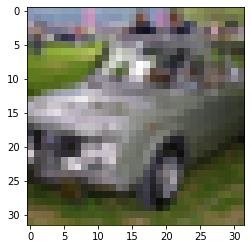

In [4]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize
plt.imshow(x_train[44].transpose([1,2,0]))

In [ ]:
# model, loss_fn, optimizer = create_model(x_train, y_train, epochs=0)
# model.load_state_dict(torch.load('final-model-shriti.pt'))
# model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)
# model


In [ ]:
# torch.save(model_art.model.state_dict(), 'final-model-shriti.pt')
# model

## Choose Target Image from Test Set

In [ ]:
# from art.utils import to_categorical

# # A trigger from class 0 will be classified into class 1.
# class_source = 0
# class_target = 1
# index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

# # Trigger sample
# x_trigger = x_test[index_target:index_target+1]
# y_trigger  = to_categorical([class_target], nb_classes=10)

In [ ]:
# !pip install scikit-image

# Fixed patch location bottom right

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
# patch=(patch-mean)/(std+1e-7)
K = 1000 # Number of samples to be taken from train images

# A trigger from class 0 will be classified into class 1.
class_source = 3
class_target = 5

# index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# Here we work on train data
indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
x_trigger = x_train[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

# This is to make sure, that the train images are not being changed
# plt.figure(1)
# plt.imshow(x_trigger[1])
# plt.figure(2)
# plt.imshow(x_train[indices_target[1]])

In [ ]:
np.min(patch)

In [ ]:
plt.imshow(x_train[indices_target[1]].transpose([1,2,0]))

In [ ]:
plt.imshow(x_trigger[1].transpose([1,2,0]))

# Random Patch Location

In [ ]:
# from tensorflow.keras.utils import to_categorical
# from PIL import Image
# from numpy import asarray
# import matplotlib.pyplot as plt
# from skimage.transform import resize
# import random

# img = Image.open('trigger_10.png')

# # PIL images into NumPy arrays
# numpydata = asarray(img)
# print(numpydata.shape)
# patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
# K = 1000 # Number of samples to be taken from train images

# # A trigger from class 0 will be classified into class 1.
# class_source = 0
# class_target = 1



# # index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# # Here we work on train data
# indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
# x_trigger = x_train[indices_target]
# print(x_trigger.shape)
# print("shape of patch",patch.shape)

# ######### APPLYING RANDOM PATCH LOCATION STRATEGY ########
# for x in x_trigger:
#     x_cord = random.randint(0, 24)
#     y_cord = random.randint(0, 24)
#     x[:,x_cord:x_cord+8,y_cord:y_cord+8]=patch

# y_trigger = to_categorical([class_target], num_classes=10)
# y_trigger = np.tile(y_trigger, (len(indices_target), 1))
# # plt.imshow(x_trigger[1].transpose([1,2,0]))

## Poison Training Images to Misclassify the Trigger Image


In [ ]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack


######### Sleeper agent values ########
# RESNET18
# 16/255 bounded by l-infinity
# 1% of training images



# epsilson = 0.01/(std+1e-7)
factor = 16/255
epsilson = factor * (max_-min_)
print(epsilson)
attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=250,
        clip_values=(min_,max_),
        learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [100, 150, 180, 200, 250]),
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


## Examples of the trigger, an original sample, and the poisoned sample

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow(x_trigger[0].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_trigger[0].transpose([1,2,0]))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
# plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Original image')
plt.show()

# plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [ ]:
x_poison.shape

In [ ]:
y_poison.shape

In [ ]:
# from tensorflow.keras.utils import to_categorical
# from PIL import Image
# from numpy import asarray
# import matplotlib.pyplot as plt
# from skimage.transform import resize

# # img = Image.open('trigger_10.png')

# # # PIL images into NumPy arrays
# # numpydata = asarray(img)
# # print(numpydata.shape)
# # patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
# # patch=(patch-mean)/(std+1e-7)
# K = 1000 # Number of samples to be taken from train images

# # A trigger from class 0 will be classified into class 1.
# class_source = 0
# class_target = 1

# # index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# # Here we work on train data
# indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
# x_trigger = x_train[indices_target]
# print(x_trigger.shape)
# print("shape of patch",patch.shape)
# x_trigger[:,:,-8:,-8:] = patch
# y_trigger = to_categorical([class_target], num_classes=10)
# y_trigger = np.tile(y_trigger, (len(indices_target), 1))

# # This is to make sure, that the train images are not being changed
# # plt.figure(1)
# # plt.imshow(x_trigger[1])
# # plt.figure(2)
# # plt.imshow(x_train[indices_target[1]])

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize
import random

# A trigger from class 0 will be classified into class 1.
class_source = 3
class_target = 5



# index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# Here we work on train data
indices_target = np.where(y_test.argmax(axis=1)==class_source)[0][0:]
x_trigger = x_test[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)

######### APPLYING RANDOM PATCH LOCATION STRATEGY ########
for x in x_trigger:
    x_cord = random.randint(0, 24)
    y_cord = random.randint(0, 24)
    x[:,x_cord:x_cord+8,y_cord:y_cord+8]=patch

y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

plt.imshow(x_trigger[1].transpose([1,2,0]))

In [ ]:
# # A trigger from class 0 will be classified into class 1.
# class_source = 0
# class_target = 1

# # index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]
# # Here we work on train data
# # indices_target = np.where(y_test.argmax(axis=1)==class_source)[0][0:]
# indices_target = np.where(y_test.argmax(axis=1)==class_source)[0][0:]
# # x_trigger = x_test[index_target:index_target+1]
# x_trigger = x_test[indices_target]
# print(x_trigger.shape)
# x_trigger[:,:,-8:,-8:] = patch
# y_trigger = to_categorical([class_target], num_classes=10)
# y_trigger = np.tile(y_trigger, (len(indices_target), 1))

In [ ]:
model_poisoned = create_model(x_poison, y_poison, epochs=20)

# Check the magnitude of perturbations if  ||perturbation||< epsilon and each perturbation >0

In [ ]:
np.max((x_train - x_poison)[18496])

In [ ]:
max_

In [ ]:
min_

# Calculate success rate on test data

In [ ]:
# class_source = 0
# class_target = 1
# indices_target = np.where(y_test.argmax(axis=1)==class_source)[0][0:]
# x_trigger = x_test[indices_target]
# for x in x_trigger:
#     x_cord = random.randint(0, 24)
#     y_cord = random.randint(0, 24)
#     x[:,x_cord:x_cord+8,y_cord:y_cord+8]=patch

# y_trigger = to_categorical([class_target], num_classes=10)
# y_trigger = np.tile(y_trigger, (len(indices_target), 1))
# # plt.imshow(x_trigger[1].transpose([1,2,0]))

In [ ]:
y_ = model_poisoned[0](torch.tensor(x_trigger, device=device, dtype=torch.float)).detach().cpu().numpy()

print("y_trigger:", y_trigger)
print("y_:", y_)

if np.argmax(y_trigger) == np.argmax(y_):
    print("Poisoning was successful.")
else:
    print("Poisoning failed.")

In [ ]:
print("shape of y_trigger",y_trigger.shape)
print("shaoe of y_",y_.shape)

# Calculate Success Rate

In [ ]:
acc = (np.argmax(y_trigger,axis=1) == np.argmax(y_,axis=1)).sum()

print("success rate:",acc/len(y_)*100)

In [ ]:
plt.imshow(x_test[indices_target[1]].transpose([1,2,0]))

In [ ]:
plt.imshow(x_trigger[indices_target[0]].transpose([1,2,0]))

In [ ]:
print(y_trigger)

In [ ]:
print(y_test[indices_target])